## Imports

In [1]:
from __future__ import print_function, division
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
import pandas as pd
from skimage import io, transform
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image, ImageDraw
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings("ignore")

plt.ion() 

## Pre-process data

In [2]:
train_path = './data/cars_train/'
test_path = './data/cars_test/'
devkit_path = './data/cars_devkit'

train_annos_path = devkit_path + '/cars_train_annos.csv'
test_annos_path = devkit_path + '/cars_test_annos.csv'
cars_meta_path = devkit_path + '/cars_meta.csv'

In [3]:
train_annos = pd.read_csv(train_annos_path, header=None)
test_annos = pd.read_csv(test_annos_path, header=None)
cars_meta = pd.read_csv(cars_meta_path, header=None)

train_annos.columns = ['file', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'label']
cars_meta.columns = ['label_details']
train_annos['label'] = train_annos['label']-1

In [4]:
def label_details(row):
    index = row['label']
    return cars_meta.loc[index, 'label_details']

train_annos['label_details'] = train_annos.apply(lambda row: label_details(row), axis=1)

## Save pre-processed data 

In [5]:
train_annos.to_csv('train_annos_cleaned.csv', index=False)
train_annos.head()

,file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,label,label_details
0,00001.jpg,39,116,569,375,13,Audi TTS Coupe 2012
1,00002.jpg,36,116,868,587,2,Acura TL Sedan 2012
2,00003.jpg,85,109,601,381,90,Dodge Dakota Club Cab 2007
3,00004.jpg,621,393,1484,1096,133,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,14,36,133,99,105,Ford F-450 Super Duty Crew Cab 2012


## Create dataloader

In [6]:
class CarsDataset(Dataset):

    def __init__(self, annos_path, data_dir, transform=None):
        """
        Args:
            annos_path (string): Path to the csv file with annotations.
            data_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.car_details = pd.read_csv(annos_path)
        self.car_details = np.array(self.car_details)

        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.car_details)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.car_details[idx][0])
        image = Image.open(img_name)
        num_channel = len(image.split())
        car_class = self.car_details[idx][5]
        car_details = self.car_details[idx][6]
        x1, y1, x2, y2 = self.car_details[idx][1], self.car_details[idx][2], self.car_details[idx][3], self.car_details[idx][4]
        bounding_box = [x1, y1, x2, y2]

        if self.transform:
            image = self.transform(image)
            
        '''
        if num_channel != 3:
            return
        '''
        
        return image, bounding_box, car_class, car_details


## Visualize training data

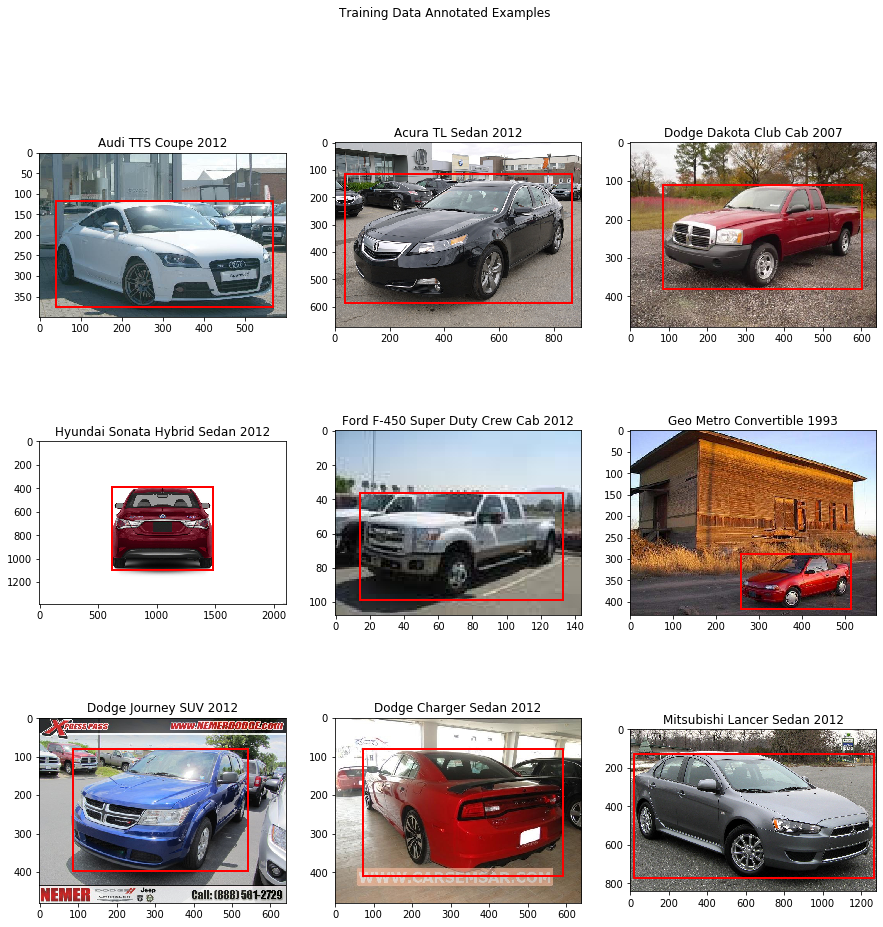

In [7]:
cars_data_train = CarsDataset('train_annos_cleaned.csv', train_path)

fig, axs = plt.subplots(3, 3, figsize=(15,15)) 
idx = 0
for i in range(3):
    for j in range(3):
        sample = cars_data_train[idx][0]
        box = cars_data_train[idx][1]
        title = cars_data_train[idx][3]

        xy = box[0], box[1]
        width = box[2] - box[0]
        height = box[3] - box[1]
        rect = Rectangle(xy, width, height, fill=False, color='r', linewidth=2)
        
        axs[i, j].imshow(sample)
        axs[i, j].set_title(title)
        axs[i, j].add_patch(rect)
        idx += 1
        
fig.suptitle("Training Data Annotated Examples")
plt.savefig("training_annotations_examples.png")

## Data distribution

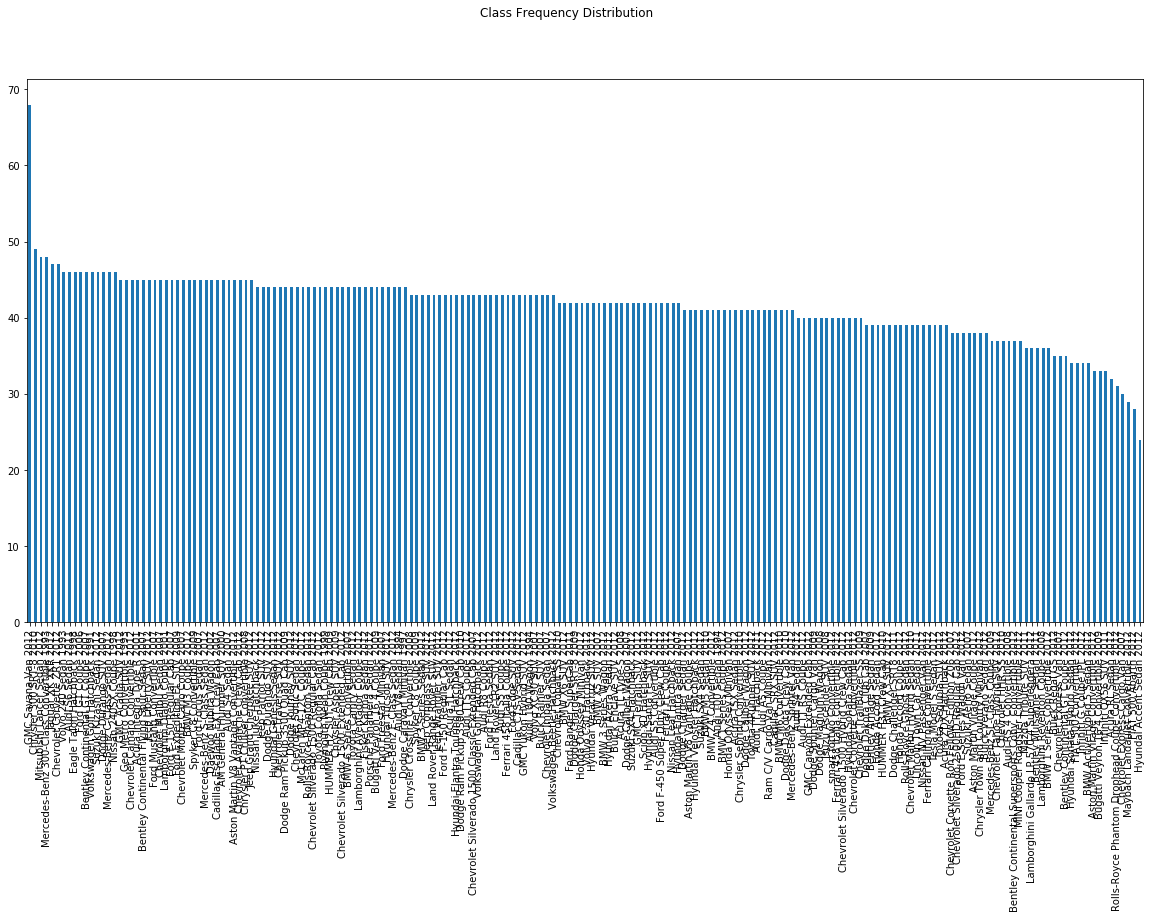

In [8]:
fig, ax = plt.subplots(figsize=(20,10))
dataset = pd.read_csv('train_annos_cleaned.csv')
dataset['label_details'].value_counts().plot(ax=ax, kind='bar')

fig.suptitle("Class Frequency Distribution")
plt.savefig("class_frequency_distribution.png")

In [ ]:
"""
MISREAD THE ASSIGNMENT, DID NOT REALIZE WE COULD USE A PRE-TRAINED MODEL, THEREBY MODIFIED THE MNIST MODEL FROM LAST WEEK (AND WASTED A LOT OF TIME ALTHOUGH IT SOMEWHAT WORKS)


cars_data_train = CarsDataset('train_annos_cleaned.csv', train_path, transform=transforms.Compose(
    [transforms.Resize(100), transforms.RandomSizedCrop(100), transforms.ToTensor()]))

class Net(nn.Module):
    '''
    Build the best MNIST classifier.
    '''
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=197, kernel_size=(3,3), stride=1)
        self.conv2 = nn.Conv2d(197, 197, 3, 1)
        self.dropout1 = nn.Dropout2d(0.15)
        self.dropout2 = nn.Dropout2d(0.15)
        self.fc1 = nn.Linear(104213, 1000)
        self.fc2 = nn.Linear(1000, 197)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)
        return output
    
def train(model, train_loader, optimizer, epoch):
    '''
    This is your training function. When you call this function, the model is
    trained for 1 epoch.
    '''
    model.train()   # Set the model to training mode
    losses = []
    for batch_idx, (data, box, target, details) in enumerate(train_loader):
        if data.size()[1] != 3:
            continue
        optimizer.zero_grad()               # Clear the gradient
        output = model(data)                # Make predictions
        loss = F.nll_loss(output, target)   # Compute loss
        losses.append(loss.item())
        loss.backward()                     # Gradient computation
        optimizer.step()                    # Perform a single optimization step
        if (batch_idx % 10 == 0):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.sampler),
                100. * batch_idx / len(train_loader), loss.item()))     
    return np.average(losses)

train_loader = torch.utils.data.DataLoader(
    cars_data_train, batch_size=64)
    
model = Net()
optimizer = optim.Adadelta(model.parameters(), lr=1.0)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
 
epochs = 1
train_loss = []
for epoch in range(epochs):
        loss = train(model, train_loader, optimizer, epoch)
        train_loss.append(loss)
        scheduler.step()  
        
torch.save(model.state_dict(), "poor.pt")
"""

In [11]:
cars_data_train = CarsDataset('train_annos_cleaned.csv', train_path, transform=transforms.Compose(
    [transforms.Resize(100), transforms.RandomSizedCrop(100), transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(
    cars_data_train, batch_size=64)

model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 197)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max')

def train_model(model, criterion, optimizer, scheduler, n_epochs = 3):
    model.train()
    for epoch in range(n_epochs):
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, bbox, labels, details = data
            if inputs.size()[1] != 3:
                continue
            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_correct += (labels==predicted).sum().item()
        epoch_acc = 100/32*running_correct/len(train_loader)
        print("Epoch %s, acc: %.4f" % (epoch+1, epoch_acc))

In [12]:
train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=10)

RuntimeError: stack expects each tensor to be equal size, but got [3, 100, 100] at entry 0 and [1, 100, 100] at entry 9